# Slow-waves detection

See https://www.spisop.org/documentation/#Slow_oscillations and https://www.spisop.org/wp-content/uploads/2016/04/SO_full-01-750x500.png

In [1]:
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mne.filter import filter_data
sns.set(font_scale=1.2)

## Data loading and preprocessing

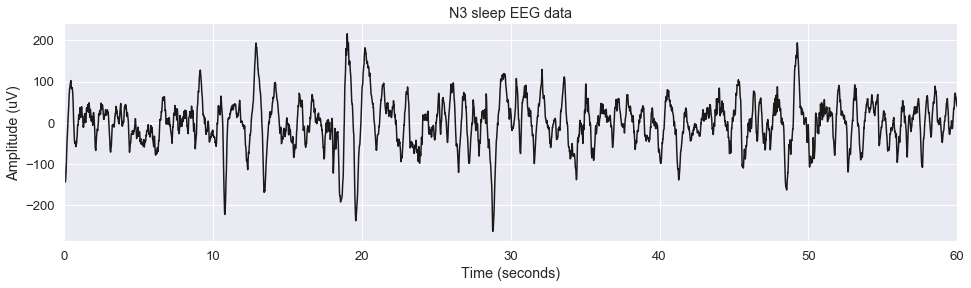

In [2]:
# Load data
data = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz').get('data')
ch_names = ['Cz', 'Fz', 'Pz']

# Keep only Fz and during a N3 sleep period with (huge) slow-waves
data = data[1, 666000:672000].astype(np.float64)

# Define sampling frequency and time vector
sf = 100.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data')
sns.despine()

Setting up band-pass filter from 0.3 - 3.5 Hz
Filter length of 1651 samples (16.510 sec) selected
Using filter length: 1651
Smart-padding with:  1650 samples on each edge
FFT block length:   4096


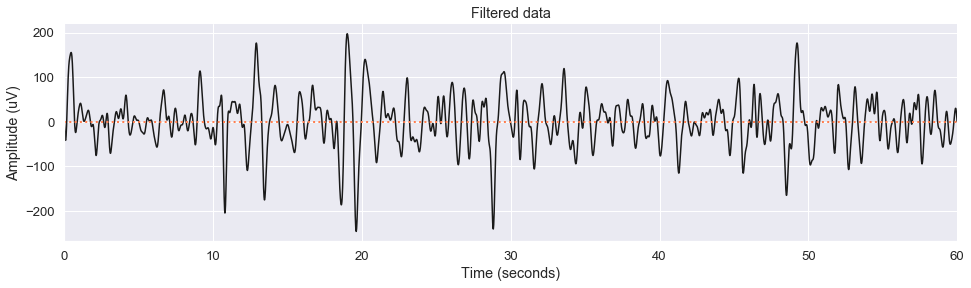

In [3]:
# Slow-waves FIR bandpass filter
freq_sw = (0.3, 3.5)
data_filt = filter_data(data, sf, freq_sw[0], freq_sw[1], method='fir', verbose=1, 
                        l_trans_bandwidth=0.2, h_trans_bandwidth=0.2)

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data_filt, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.axhline(0, color='coral', ls=':', lw=2)
plt.title('Filtered data')
sns.despine()

## Method 1: Broadcasting

### Compute the relative delta power at each sample

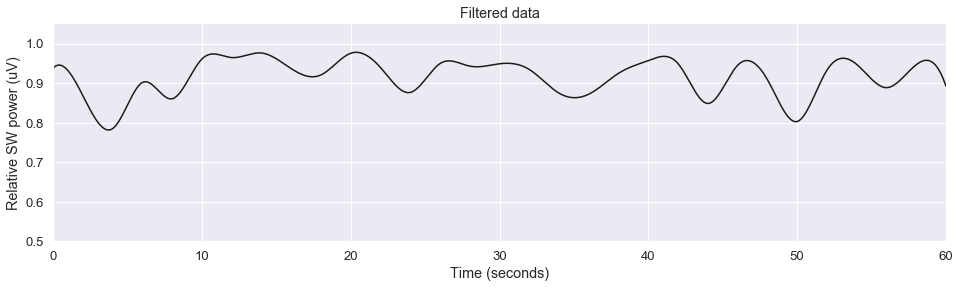

In [4]:
from scipy.interpolate import interp1d

# Compute the pointwise relative power using interpolated STFT
# Here we use a step of 200 ms to speed up the computation.
f, t, Sxx = yasa.main.stft_power(data, sf, window=5, step=2, interp=False, norm=True)
idx_sw = np.logical_and(f >= 0.5, f <= 3.5)
sw_rel_pow = Sxx[idx_sw].sum(0)

# Let's interpolate `rel_pow` to get one value per sample
# Note that we could also have use the `interp=True` in the `stft_power`
# function, however 2D interpolation is much slower than
# 1D interpolation.
func = interp1d(t, sw_rel_pow, kind='cubic', bounds_error=False,
                fill_value=0)
t = np.arange(data.size) / sf
sw_rel_pow = func(t)

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, sw_rel_pow, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Relative SW power (uV)')
plt.xlim([times.min(), times.max()])
plt.ylim(0.5, 1.05)
plt.title('Filtered data')
sns.despine()

### Main detection

In [5]:
from scipy.signal import find_peaks

# Negative peaks with value comprised between -40 to -200 uV
idx_neg_peaks, _ = find_peaks(-1 * data_filt, height=(40, 200))

# Positive peaks with values comprised between 10 to 150 uV
idx_pos_peaks, _ = find_peaks(data_filt, height=(20, 150))

print(idx_neg_peaks)
print(idx_pos_peaks)

[   8  214  310  622  880 1015 1230 1345 1460 1546 1745 1812 1861 2098
 2241 2265 2331 2356 2386 2647 2721 2788 3063 3158 3268 3402 3437 3552
 3684 3839 4005 4129 4472 4562 4706 4745 4852 4884 5013 5176 5270 5356
 5480 5536 5600 5662 5763 5903 5953]
[ 108  161  350  380  414  667  746  912 1039 1055 1104 1130 1145 1178
 1416 1581 1668 1704 1715 1767 2021 2141 2213 2304 2421 2512 2549 2606
 2687 2747 2809 2832 2954 3040 3090 3210 3357 3466 3506 3611 3633 3712
 3722 3786 3885 3951 4053 4174 4289 4315 4339 4397 4425 4531 4634 4675
 4795 4961 5087 5112 5149 5201 5313 5396 5428 5459 5509 5638 5712 5738
 5797 5850 5928 5989]


In [6]:
def find_closest(a, time='following'):
    if time == 'following':
        pos = a[a > 0]
        m = np.min(pos) if pos.size else 0
    elif time == 'previous':
        neg = a[a < 0]
        m = np.max(neg) if neg.size else 0
    return m
        
def crossings_nonzero_all(dta):
    pos = dta > 0
    npos = ~pos
    return ((pos[:-1] & npos[1:]) | (npos[:-1] & pos[1:])).nonzero()[0]

In [7]:
distance_peaks = idx_pos_peaks[:, None] - idx_neg_peaks

# For each negative peaks, we find the closest positive peak
closest_pos_peaks = np.apply_along_axis(find_closest, 0, distance_peaks, time='following')
idx_neg_peaks = idx_neg_peaks[np.nonzero(closest_pos_peaks)]
closest_pos_peaks = closest_pos_peaks[np.nonzero(closest_pos_peaks)]
idx_pos_peaks = idx_neg_peaks + closest_pos_peaks
idx_pos_peaks

array([ 108,  350,  350,  667,  912, 1039, 1416, 1416, 1581, 1581, 1767,
       2021, 2021, 2141, 2304, 2304, 2421, 2421, 2421, 2687, 2747, 2809,
       3090, 3210, 3357, 3466, 3466, 3611, 3712, 3885, 4053, 4174, 4531,
       4634, 4795, 4795, 4961, 4961, 5087, 5201, 5313, 5396, 5509, 5638,
       5638, 5712, 5797, 5928, 5989], dtype=int64)

In [8]:
# Now we check sure that the PTP amplitude is correct
sw_ptp = abs(data_filt[idx_neg_peaks]) + data_filt[idx_pos_peaks]
# distance = (closest_pos_peaks / sf)  # Distance between two peaks in seconds
good_ptp = np.logical_and(sw_ptp > 75, sw_ptp < 400)
print(sw_ptp)
print(good_ptp)

[ 83.15369117  98.25597529  93.42697752 128.32628976 165.2429188
  86.23599652 190.67100267 256.72377272 110.04251706 136.3903978
  73.77144267 199.93787661 326.11485036 159.72422446 142.58289826
 176.83852916  74.71971673  77.55104013 100.06817896 171.91346457
 132.06722542  89.82631109 133.00780566 191.12252554 170.28145056
  83.31480165 115.37280085 116.00642208  90.74786428  99.80455916
 169.04324707 160.89747252 173.17615745 198.96663037 113.78428279
 106.1395964  189.77373313  85.5194512  128.50619682 153.92049422
 185.65665353 144.46268371  67.85887979 110.80326104 118.88127424
  89.85127109 150.628716    80.22307305  80.71353247]
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True]


In [9]:
# Now we need to check the negative and positive phase duration
# First let's compute the zero crossings of the filtered signal
zero_crossings = crossings_nonzero_all(data_filt)
zero_crossings

array([   0,   16,   68,   86,  175,  235,  264,  279,  294,  336,  429,
        460,  500,  551,  588,  640,  708,  733,  758,  799,  818,  841,
        864,  892,  940, 1026, 1063, 1097, 1190, 1258, 1326, 1378, 1442,
       1563, 1608, 1641, 1731, 1757, 1796, 1828, 1830, 1880, 1939, 1995,
       2075, 2124, 2225, 2282, 2319, 2406, 2452, 2500, 2526, 2533, 2562,
       2582, 2627, 2667, 2705, 2735, 2775, 2797, 2844, 2913, 2997, 3027,
       3050, 3076, 3118, 3181, 3234, 3285, 3299, 3326, 3380, 3457, 3475,
       3488, 3534, 3577, 3648, 3656, 3669, 3696, 3739, 3770, 3820, 3864,
       3897, 3939, 3984, 4026, 4105, 4159, 4192, 4279, 4349, 4371, 4436,
       4490, 4547, 4600, 4607, 4619, 4646, 4662, 4690, 4723, 4730, 4757,
       4829, 4896, 4973, 5052, 5057, 5074, 5160, 5187, 5250, 5296, 5331,
       5377, 5470, 5493, 5520, 5565, 5580, 5617, 5650, 5673, 5689, 5697,
       5749, 5781, 5812, 5832, 5867, 5919, 5937, 5977, 5998], dtype=int64)

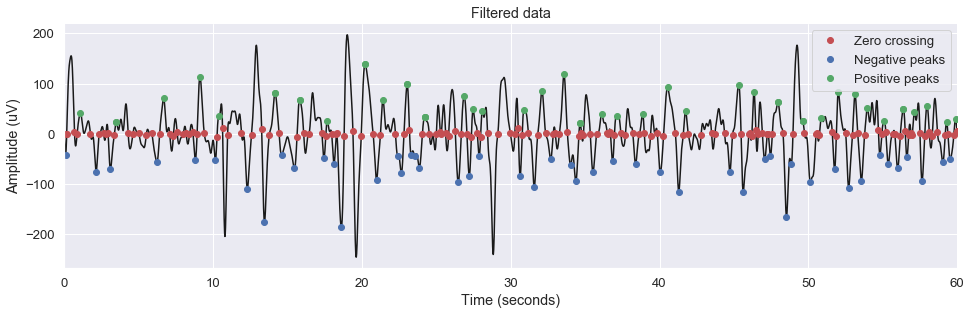

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4.5))
plt.plot(times, data_filt, lw=1.5, color='k')
plt.plot(times[zero_crossings], data_filt[zero_crossings], 'ro', label='Zero crossing')
plt.plot(times[idx_neg_peaks], data_filt[idx_neg_peaks], 'bo', label='Negative peaks')
plt.plot(times[idx_pos_peaks], data_filt[idx_pos_peaks], 'go', label='Positive peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('Filtered data')
plt.legend()
sns.despine()

In [11]:
# Distance (in samples) between the negative peaks and the previous and following zero-crossings
distance_neg_to_zc = zero_crossings[:, None] - idx_neg_peaks

# Find distance to previous and following zc
previous_neg_zc = np.apply_along_axis(find_closest, 0, distance_neg_to_zc, time='previous')
following_neg_zc = np.apply_along_axis(find_closest, 0, distance_neg_to_zc, time='following')
neg_phase_dur = (abs(previous_neg_zc) + following_neg_zc) / sf

print(previous_neg_zc)
print(following_neg_zc)
print(neg_phase_dur)

[  -8  -39  -16  -34  -16  -75  -40  -19  -18 -104  -14  -16  -31  -23
  -16  -40  -12  -37  -67  -20  -16  -13  -13  -40  -34  -22  -57  -18
  -15  -19  -21  -24  -36  -15  -16  -15  -23  -55  -40  -16  -20  -25
  -10  -16  -20  -12  -14  -36  -16]
[  8  21  26  18  12  11  28  33 103  17  12  16  19  26  41  17  75  50
  20  20  14   9  13  23  17  55  20  25  12  25  21  30  18  38  17  12
  44  12  39  11  26  21  13  29  17  11  18  16  24]
[0.16 0.6  0.42 0.52 0.28 0.86 0.68 0.52 1.21 1.21 0.26 0.32 0.5  0.49
 0.57 0.57 0.87 0.87 0.87 0.4  0.3  0.22 0.26 0.63 0.51 0.77 0.77 0.43
 0.27 0.44 0.42 0.54 0.54 0.53 0.33 0.27 0.67 0.67 0.79 0.27 0.46 0.46
 0.23 0.45 0.37 0.23 0.32 0.52 0.4 ]


In [12]:
# Distance (in samples) between the positive peaks and the previous and following zero-crossings
distance_pos_to_zc = zero_crossings[:, None] - idx_pos_peaks

# Find distance to previous and following zc
previous_pos_zc = np.apply_along_axis(find_closest, 0, distance_pos_to_zc, time='previous')
following_pos_zc = np.apply_along_axis(find_closest, 0, distance_pos_to_zc, time='following')
pos_phase_dur = (abs(previous_pos_zc) + following_pos_zc) / sf

print(previous_pos_zc)
print(following_pos_zc)
print(pos_phase_dur)

[-22 -14 -14 -27 -20 -13 -38 -38 -18 -18 -10 -26 -26 -17 -22 -22 -15 -15
 -15 -20 -12 -12 -14 -29 -31  -9  -9 -34 -16 -21 -27 -15 -41 -15 -38 -38
 -65 -65 -13 -14 -17 -19 -16 -21 -21 -15 -16  -9 -12]
[67 79 79 41 28 24 26 26 27 27 29 54 54 84 15 15 31 31 31 18 28 35 28 24
 23  9  9 37 27 12 52 18 16 12 34 34 12 12 73 49 18 74 11 12 12 37 15  9
  9]
[0.89 0.93 0.93 0.68 0.48 0.37 0.64 0.64 0.45 0.45 0.39 0.8  0.8  1.01
 0.37 0.37 0.46 0.46 0.46 0.38 0.4  0.47 0.42 0.53 0.54 0.18 0.18 0.71
 0.43 0.33 0.79 0.33 0.57 0.27 0.72 0.72 0.77 0.77 0.86 0.63 0.35 0.93
 0.27 0.33 0.33 0.52 0.31 0.18 0.21]


In [13]:
# Define start and end
sw_start = times[idx_neg_peaks + previous_neg_zc]
sw_end = times[idx_pos_peaks + following_pos_zc]
sw_dur = sw_end - sw_start  # Same as pos_phase_dur + neg_phase_dur
sw_midcrossing = times[idx_neg_peaks + following_neg_zc]
sw_idx_neg, sw_idx_pos = times[idx_neg_peaks], times[idx_pos_peaks]
sw_slope = sw_ptp / (sw_midcrossing - sw_idx_neg)  # Slope between peak trough and midcrossing

In [14]:
# Finally we apply a set of thresholds to remove bad slow waves
good_sw = np.logical_and.reduce((previous_neg_zc != 0, 
                                 following_neg_zc != 0,
                                 previous_pos_zc != 0, 
                                 following_pos_zc != 0,
                                 neg_phase_dur > 0.125, 
                                 neg_phase_dur < 1.5,
                                 pos_phase_dur < 1, 
                                 sw_midcrossing > sw_start,
                                 sw_midcrossing < sw_end, 
                                 good_ptp
                                ))
good_sw

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True])

In [15]:
# Create the dataframe
sw = pd.DataFrame({'Start': sw_start,
                   'NegPeak': sw_idx_neg,
                   'MidCrossing': sw_midcrossing,
                   'PosPeak': sw_idx_pos,  
                   'End': sw_end, 
                   'Duration': sw_dur,
                   'ValNegPeak': data_filt[idx_neg_peaks], 
                   'ValPosPeak': data_filt[idx_pos_peaks], 
                   'PTP': sw_ptp, 
                   'Slope': sw_slope, 
                   'Frequency': 1 / sw_dur,
                    })[good_sw]

# Remove all duplicates and reset index
sw.drop_duplicates(subset=['Start'], inplace=True, keep=False)
sw.drop_duplicates(subset=['End'], inplace=True, keep=False)
sw.reset_index(drop=True, inplace=True)
sw.round(3)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
0,0.00,0.08,0.16,1.08,1.75,1.75,-41.766,41.388,83.154,1039.421,0.571
1,5.88,6.22,6.40,6.67,7.08,1.20,-57.000,71.326,128.326,712.924,0.833
2,8.64,8.80,8.92,9.12,9.40,0.76,-51.620,113.623,165.243,1377.024,1.316
3,9.40,10.15,10.26,10.39,10.63,1.23,-51.737,34.499,86.236,783.964,0.813
4,26.27,26.47,26.67,26.87,27.05,0.78,-96.542,75.371,171.913,859.567,1.282
5,27.05,27.21,27.35,27.47,27.75,0.70,-83.390,48.677,132.067,943.337,1.429
6,27.75,27.88,27.97,28.09,28.44,0.69,-44.072,45.754,89.826,998.070,1.449
7,30.50,30.63,30.76,30.90,31.18,0.68,-84.844,48.163,133.008,1023.137,1.471
8,31.18,31.58,31.81,32.10,32.34,1.16,-105.905,85.217,191.123,830.968,0.862
9,32.34,32.68,32.85,33.57,33.80,1.46,-51.149,119.133,170.281,1001.656,0.685


## Plot

In [16]:
# Let's get a bool vector indicating for each sample
bool_sw = yasa.get_bool_vector(data_filt, sf, sw)
bool_sw

array([1, 1, 1, ..., 1, 1, 0])

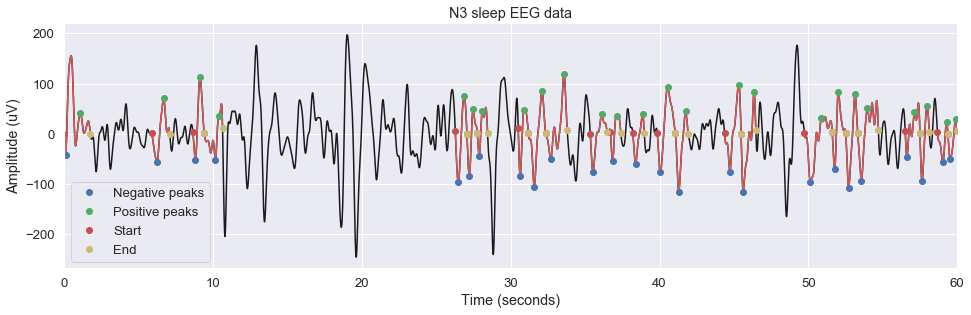

In [17]:
# Now let's plot
sw_highlight = data_filt * bool_sw
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))
plt.plot(times, data_filt, 'k')
plt.plot(times, sw_highlight, 'indianred')
plt.plot(sw['NegPeak'], sw['ValNegPeak'], 'bo', label='Negative peaks')
plt.plot(sw['PosPeak'], sw['ValPosPeak'], 'go', label='Positive peaks')
plt.plot(sw['Start'], data_filt[(sw['Start'] * sf).astype(int)], 'ro', label='Start')
plt.plot(sw['End'], data_filt[(sw['End'] * sf).astype(int)], 'yo', label='End')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N3 sleep EEG data')
plt.legend()
sns.despine()

## Method #2: using for loop

In [18]:
# from scipy.signal import argrelmin

# # Find all the values that are < -40 uV
# idx_neg_below_40 = np.where(data_filt < -40)[0]

# # Now find the local negative peaks in these supra-threshold clusters
# idx_neg_peak = idx_neg_below_40[argrelmin(data_filt[idx_neg_below_40])[0]]
# val_neg_peak = data_filt[idx_neg_peak]

# print(idx_neg_peak)
# print(val_neg_peak)

2. Now, for each of these negative peaks, we find the closest positive peak value in the 2 following seconds. Note that the peak-to-peak amplitude must be > 75 uV.

In [19]:
# from scipy.signal import argrelmax, find_peaks

# # Define empty vectors
# ptp_criterion = np.zeros(idx_neg_peak.shape, dtype=bool)
# idx_pos_peak = np.zeros(idx_neg_peak.shape, dtype=int)
# val_pos_peak = np.zeros(idx_neg_peak.shape)

# for i, (idx_pk, val_neg_pk) in enumerate(zip(idx_neg_peak, val_neg_peak)):
#     print(i, idx_pk, val_neg_pk)
#     idx = np.arange(idx_pk, idx_pk + 2 * sf, dtype=int)
#     # Make sure that our index vector stay in bounds of data
#     if idx[-1] > data_filt.size:
#         idx = idx[idx < data_filt.size]
#     # Find closest maxima that satisfies ptp amplitude
#     height = 75 + val_neg_pk
#     idx_maxima = find_peaks(data_filt[idx], height=height)[0]
#     # Append good slow waves
#     if len(idx_maxima) >= 1:
#         idx_pos_peak[i] = idx[idx_maxima[0]]
#         ptp_criterion[i] = True
    
# # Keep only good SW
# idx_neg_peak = idx_neg_peak[ptp_criterion]
# idx_pos_peak = idx_pos_peak[ptp_criterion]
# print(idx_neg_peak, idx_pos_peak)

3. Now check the deflection length

In [20]:
# def crossings_nonzero_all(data):
#     pos = data > 0
#     npos = ~pos
#     return ((pos[:-1] & npos[1:]) | (npos[:-1] & pos[1:])).nonzero()[0]

# zero_crossings = crossings_nonzero_all(data_filt)
# zero_crossings

In [21]:
# neg_dur_thres = (sf * 0.125, sf * 1.5)
# pos_dur_thres = 1 * sf

# crit_neg_deflection = np.zeros(idx_neg_peak.shape, dtype=bool)
# crit_pos_deflection = np.zeros(idx_pos_peak.shape, dtype=bool)
# dur_neg_deflection = np.zeros(idx_neg_peak.shape)  # In seconds
# dur_pos_deflection = np.zeros(idx_neg_peak.shape)  # In seconds

# for i, (idx_neg_pk, idx_pos_pk) in enumerate(zip(idx_neg_peak, idx_pos_peak)):
#     print(i, idx_neg_pk, idx_pos_pk)
    
#     # Negative peak
#     distance_zc = idx_neg_pk - zero_crossings
#     previous_zc = np.max(distance_zc[distance_zc < 0])
#     next_zc = np.min(distance_zc[distance_zc > 0])
#     dur_neg = (-1 * previous_zc + next_zc)
#     if neg_dur_thres[0] < dur_neg < neg_dur_thres[1]:
#         dur_neg_deflection[i] = dur_neg / sf
#         crit_neg_deflection[i] = True
    
#     # Positive peak
#     distance_zc = idx_pos_pk - zero_crossings
#     previous_zc = np.max(distance_zc[distance_zc < 0])
#     next_zc = np.min(distance_zc[distance_zc > 0])
#     dur_pos = (-1 * previous_zc + next_zc)
#     if dur_pos < pos_dur_thres:
#         dur_pos_deflection[i] = dur_pos / sf
#         crit_pos_deflection[i] = True
        
# # Keep only good SW
# def_criterion = np.logical_and(crit_neg_deflection, crit_pos_deflection)
# idx_neg_peak = idx_neg_peak[def_criterion]
# idx_pos_peak = idx_pos_peak[def_criterion]
# dur_neg_deflection = dur_neg_deflection[def_criterion]
# dur_pos_deflection = dur_pos_deflection[def_criterion]
# print(dur_neg_deflection, dur_pos_deflection)